Importieren der notwendigen Bibliotheken

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB

Laden und Vorbereiten der Daten

In [3]:
df = pd.read_csv('data/churn_data_encoded.csv')
df_test = pd.read_csv('data/churn_data.csv')

print(len(df_test))
print(len(df_test.dropna()))

7043
2493


Evaluierungsfunktion

In [4]:
def custom_score(y_true, y_pred):
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    total = len(y_true)
    score = (fp + 5 * fn) / total
    return score

def print_scores(scores):
    scores_df = pd.DataFrame({
        'Fold': np.arange(1, len(scores['test_accuracy']) + 1),
        'Accuracy': scores['test_accuracy'],
        'Precision': scores['test_precision'],
        'Recall': scores['test_recall'],
        'F1': scores['test_f1'],
        'Custom Score': scores['test_custom_score'],
    })
    print("Scores:\n", scores_df)

    metrics = ['accuracy', 'precision', 'recall', 'f1', 'custom_score']
    statistics = pd.DataFrame(index=metrics, columns=['Min', 'Mean', 'Max'])

    for metric in metrics:
        statistics.loc[metric, 'Min'] = scores['test_' + metric].min()
        statistics.loc[metric, 'Mean'] = scores['test_' + metric].mean()
        statistics.loc[metric, 'Max'] = scores['test_' + metric].max()
    print("\nStatistics:\n", statistics)

def evaluate_classification(X, y, classifier):
    custom_scorer = make_scorer(custom_score, greater_is_better=False)
    cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=42)

    scores = cross_validate(
        classifier,
        X,
        y,
        cv=cv,
        scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'custom_score': custom_scorer,
        }
    )
    print_scores(scores)
    return scores

Trainieren und Evaluieren des Naive Bayes Modells

In [5]:
X = df.drop('Churn', axis=1)
y = df['Churn']

clf = GaussianNB()
scores = evaluate_classification(X, y, clf)

Scores:
    Fold  Accuracy  Precision    Recall        F1  Custom Score
0     1  0.823279   0.618147  0.874332  0.724252     -0.310149
1     2  0.809084   0.591944  0.903743  0.715344     -0.293116
2     3  0.836764   0.635849  0.901070  0.745575     -0.268275
3     4  0.810369   0.600000  0.852547  0.704319     -0.345881
4     5  0.798295   0.581818  0.855615  0.692641     -0.355114

Statistics:
                    Min      Mean       Max
accuracy      0.798295  0.815558  0.836764
precision     0.581818  0.605552  0.635849
recall        0.852547  0.877461  0.903743
f1            0.692641  0.716426  0.745575
custom_score -0.355114 -0.314507 -0.268275


Balancieren der Klassen und Skalieren der Features

In [6]:
# Balancieren der Klassen
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(y_resampled.value_counts())

# Skalieren der Features
scaler = MinMaxScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Trainieren und Evaluieren des Naive Bayes Modells nach Balancing
clf = GaussianNB()
scores = evaluate_classification(X_resampled_scaled, y_resampled, clf)

Churn
0    5174
1    5174
Name: count, dtype: int64
Scores:
    Fold  Accuracy  Precision    Recall        F1  Custom Score
0     1  0.628019   0.573816  0.995169  0.727915     -0.381643
1     2  0.615459   0.566278  0.986473  0.719521     -0.411594
2     3  0.636232   0.579303  0.995169  0.732314     -0.373430
3     4  0.638473   0.580974  0.992263  0.732857     -0.376994
4     5  0.634123   0.578090  0.994203  0.731083     -0.377477

Statistics:
                    Min      Mean       Max
accuracy      0.615459  0.630461  0.638473
precision     0.566278  0.575692  0.580974
recall        0.986473  0.992656  0.995169
f1            0.719521  0.728738  0.732857
custom_score -0.411594 -0.384227  -0.37343


Klassifikation mit ausgewählten Features

In [7]:
# Sortieren der Korrelationen
correlations = df.corr()
sorted_corrs = correlations['Churn'].abs().sort_values(ascending=False).drop('Churn')
print(sorted_corrs)

# Features nacheinander hinzufügen und evaluieren
selected_features = []
for feature in sorted_corrs.index:
    selected_features.append(feature)
    if len(selected_features) == 1:
        continue

    X_temp = X_resampled_scaled[:, df.columns.get_loc(feature)]
    clf = GaussianNB()
    scores = evaluate_classification(X_temp.reshape(-1, 1), y_resampled, clf)

    if len(selected_features) == 10:
        break

Satisfaction Score            0.754649
Contract_Month-to-Month       0.448427
Tenure in Months              0.352861
Contract_Two Year             0.328195
Number of Referrals           0.286540
                                ...   
City_Sequoia National Park    0.000830
City_Wasco                    0.000830
City_Visalia                  0.000659
City_Los Angeles              0.000397
City_Ontario                  0.000136
Name: Churn, Length: 1155, dtype: float64
Scores:
    Fold  Accuracy  Precision    Recall        F1  Custom Score
0     1  0.571014   0.544144  0.875362  0.671111     -0.678261
1     2  0.577295   0.548960  0.866667  0.672162     -0.689372
2     3  0.570531   0.543349  0.884058  0.673042     -0.661353
3     4  0.555341   0.534545  0.852998  0.657228     -0.738521
4     5  0.574190   0.546163  0.880193  0.674066     -0.665539

Statistics:
                    Min      Mean       Max
accuracy      0.555341  0.569674  0.577295
precision     0.534545  0.543432   0.54896

Finales Training und Evaluierung

In [8]:
# Finale Modelltraining und Evaluierung mit besten Features
selected_features = sorted_corrs[:6].index.to_list()
X_resampled, y_resampled = smote.fit_resample(X[selected_features], y)
X_resampled_scaled = scaler.fit_transform(X_resampled)

model = GaussianNB()
model.fit(X_resampled_scaled, y_resampled)
y_pred = model.predict(X_resampled_scaled)

result = classification_report(y_resampled, y_pred)
print(result)

conf_matrix = confusion_matrix(y_resampled, y_pred)
print(conf_matrix)
conf_matrix_rel = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
print(conf_matrix_rel)

fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
cost = fp + 5 * fn
print("Cost: ", cost)

import joblib
joblib.dump(model, 'models/naive_bayes_model.pkl')

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      5174
           1       0.85      0.95      0.89      5174

    accuracy                           0.89     10348
   macro avg       0.89      0.89      0.89     10348
weighted avg       0.89      0.89      0.89     10348

[[4278  896]
 [ 282 4892]]
[[0.82682644 0.17317356]
 [0.05450329 0.94549671]]
Cost:  2306


['models/naive_bayes_model.pkl']

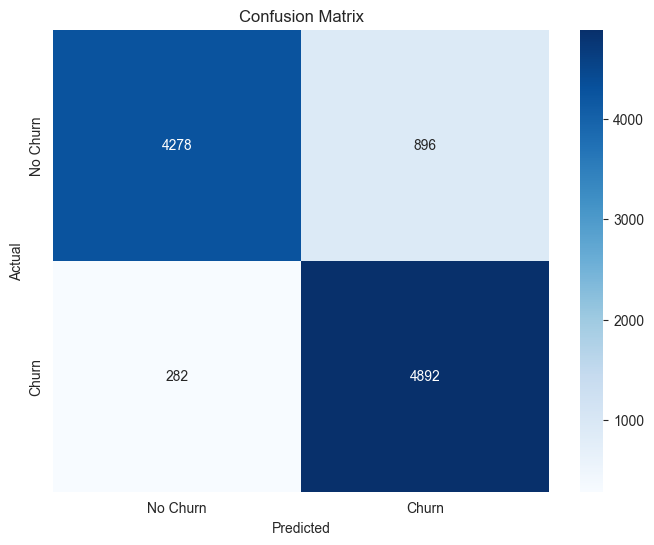

In [9]:
import seaborn as sns

conf_matrix = confusion_matrix(y_resampled, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()